# Brain Tumor Classification using Deep Learning (PyTorch)

 Brain Tumor Classification using Deep Learning (PyTorch)
------------------------------------------------------------
This project aims to classify MRI brain scans into 4 tumor types:
 1. Glioma Tumor

 2. Meningioma Tumor

 3. Pituitary Tumor

 4. No Tumor

 ✅ We used a transfer learning approach with a pre-trained CNN (e.g., ResNet18).

 ✅ The dataset was preprocessed and merged from multiple sources.

 ✅ The model was trained, validated, and tested — achieving an accuracy of ~91.
 55%.

 ✅ A real-time image prediction interface was built using Gradio.


 ⚠️ Note: Fine-tuning was attempted on a small real-world dataset, but it reduced performance.

 Therefore, it has been excluded from the final version.


# Project Setup

Let’s begin by setting up the environment and checking for GPU

In [1]:
# Import required libraries
import os
from PIL import Image
import numpy as np
import torch
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader
import torch.nn as nn

# set up device agnostic code
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# Define Image Transformations

In [2]:
transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),                      # Convert to PyTorch tensor
    transforms.Resize((224,224)),                # Resize all images
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale image
])



# Load and Prepare the Dataset

**Then unzip like this:**

In [3]:
from google.colab import files

# upload the zip files
uploaded=files.upload()

Saving Testing.zip to Testing.zip
Saving Testing1.zip to Testing1.zip
Saving Training.zip to Training.zip
Saving Training1.zip to Training1.zip


In [4]:
import zipfile

with zipfile.ZipFile("Training.zip", "r") as zip_ref:
  zip_ref.extractall("BrainTumourDataset/Training")

with zipfile.ZipFile("Testing.zip", "r") as zip_ref:
  zip_ref.extractall("BrainTumourDataset/Testing")

with zipfile.ZipFile("Training1.zip", "r") as zip_ref:
  zip_ref.extractall("BrainTumourDataset/Training1")

with zipfile.ZipFile("Testing1.zip", "r") as zip_ref:
  zip_ref.extractall("BrainTumourDataset/Testing1")

This block merges the original dataset folders ("Training", "Testing")
with additional datasets ("Training1", "Testing1") to create a combined dataset  

In [8]:
# Merging Datasets

import os
import shutil #  used to move or copy files from one place to another

def merge_folders(source_dir, target_dir):
  for class_name in os.listdir(source_dir):
    source_class_dir=os.path.join(source_dir, class_name)
    target_class_dir=os.path.join(target_dir, class_name)

    if not os.path.exists(target_class_dir):
      os.makedirs(target_class_dir)

    for filename in os.listdir(source_class_dir):
      shutil.move(
          os.path.join(source_class_dir, filename),
          os.path.join(target_class_dir, filename)
      )
# Merge new data into existing old folders
merge_folders("BrainTumourDataset/Training1/Training", "BrainTumourDataset/Training/Training")
merge_folders("BrainTumourDataset/Testing1/Testing", "BrainTumourDataset/Testing/Testing")

Merging duplicate class folders to maintain only 4 unique classes.

 For example, 'glioma_tumor' and 'glioma' contain the same type of data,

 so we move all files into a single 'glioma' folder.

 This helps ensure a clean and unified dataset structure for training and testing.

In [9]:
# Merging class folders

import os
import shutil

def merge_names(source_folder, target_folder):
  if os.path.exists(source_folder) and os.path.exists(target_folder):
    for filename in os.listdir(source_folder):
      shutil.move(os.path.join(source_folder,filename), os.path.join(target_folder, filename))
    os.rmdir(source_folder)

merge_names('BrainTumourDataset/Training/Training/glioma_tumor', 'BrainTumourDataset/Training/Training/glioma')
merge_names('BrainTumourDataset/Training/Training/meningioma_tumor', 'BrainTumourDataset/Training/Training/meningioma')
merge_names('BrainTumourDataset/Training/Training/pituitary_tumor', 'BrainTumourDataset/Training/Training/pituitary')
merge_names('BrainTumourDataset/Training/Training/no_tumor', 'BrainTumourDataset/Training/Training/notumor')

# for testing
merge_names('BrainTumourDataset/Testing/Testing/glioma_tumor', 'BrainTumourDataset/Testing/Testing/glioma')
merge_names('BrainTumourDataset/Testing/Testing/meningioma_tumor', 'BrainTumourDataset/Testing/Testing/meningioma')
merge_names('BrainTumourDataset/Testing/Testing/pituitary_tumor', 'BrainTumourDataset/Testing/Testing/pituitary')
merge_names('BrainTumourDataset/Testing/Testing/no_tumor', 'BrainTumourDataset/Testing/Testing/notumor')


In [10]:
# Defining the paths for the cleaned and merged dataset directories

train_dir="BrainTumourDataset/Training/Training"
test_dir="BrainTumourDataset/Testing/Testing"

train_data=datasets.ImageFolder(root=train_dir, transform=transform)
test_data=datasets.ImageFolder(root=test_dir, transform=transform)


In [11]:
# create dataloaders

train_dataloader=DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader=DataLoader(test_data, batch_size=32, shuffle=False)

# Visualizing data

In [13]:
# Checking the final class names after merging folders

class_names=train_data.classes
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [18]:
# function to display images from the training dataset

import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Helper function to unnormalize and showm images
def imshow(img, title=None):
  img=img*0.5+0.5   # Unnormalize (mean=[0.5], std=[0.5]) was used
  nping=img.numpy()
  plt.imshow(np.transpose(nping, (1,2,0)), cmap='gray')  # Use cmap for grayscale
  if title:
    plt.title(title)
  plt.tight_layout()
  plt.axis('off')
  plt.show()

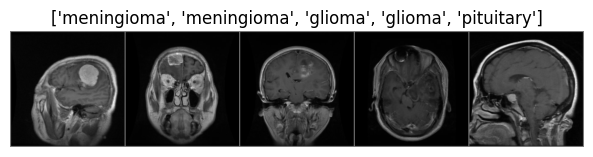

In [19]:
# Get a batch of training data
data_iter=iter(train_dataloader)
images, labels=next(data_iter)

# Show images
imshow(torchvision.utils.make_grid(images[:5]), title=[class_names[i] for i in labels[:5]])

# Load Pretrained ResNet18 and Modify Final Layer

In [20]:
# Load pre-trained ResNet18 model
model=models.resnet18(pretrained=True)

# freeze aearly layers (optinal: makes learning faster)
for param in model.parameters():
  param.requires_grad=False

# Replace the final fully connected layer (original has 1000 outputs)
num_features=model.fc.in_features
model.fc=nn.Linear(num_features, 4)

# send the model to device
model=model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


We load a pre-trained ResNet18 model from PyTorch's torchvision.models.

It has been trained on the ImageNet dataset (1.2 million images, 1000 classes).

The early layers have already learned to detect generic features like edges, textures, and shapes — which are useful for almost all vision tasks.



We freeze all layers so that their weights do not get updated during training.

# Define Loss Function and Optimizer

In [21]:
loss_fxn=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(params=model.parameters(), lr=0.001)

# Define Custom Accuracy function

In [22]:
def accuracy(y_true,y_pred):
  correct=(y_true==y_pred).sum().item()
  total=len(y_true)
  return (correct/total)*100

# Define the Training Function

In [24]:
# Train function

def train(model, dataloader, loss_fxn, optimizer, accuracy_fn, device):
  # Set the model to training mode
  model.train()

  train_loss=0
  train_acc=0

  # Empty lists to store true and predicted labels
  all_preds = []
  all_labels = []

  for images, labels in dataloader:

    # send data to the device
    images = images.to(device)
    labels = labels.to(device)

    # 1. forward pass
    outputs=model(images)

    # 2. calculate the loss/acc
    loss=loss_fxn(outputs, labels)
    acc=accuracy_fn(labels, outputs.argmax(dim=1))

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # 6. Accumulate loss and acc
    train_loss+=loss.item()
    train_acc+=acc

    # get predictions
    _, preds=torch.max(outputs, dim=1)

    all_preds+=preds.cpu().tolist()
    all_labels+=labels.cpu().tolist()

# Average over all batches
  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)

  return train_loss, train_acc, all_preds, all_labels

# Define the Validation Function

In [25]:
# validation function

def test(model, dataloader, loss_fxn, accuracy_fn, device):
  # Set the model in evaluation mode
  model.eval()

  test_loss=0
  test_acc=0

  all_preds=[]
  all_labels=[]

  with torch.inference_mode():
    for images, labels in dataloader:
      images, labels=images.to(device), labels.to(device)

      # 1. forward pass
      outputs=model(images)

      # 2. calculate the loss/acc
      loss=loss_fxn(outputs, labels)
      acc=accuracy_fn(labels, outputs.argmax(dim=1))

      test_loss+=loss.item()
      test_acc+=acc

      # get predictions
      _, preds=torch.max(outputs, dim=1)
      all_preds+=preds.cpu().tolist()
      all_labels+=labels.cpu().tolist()

    test_loss/=len(dataloader)
    test_acc/=len(dataloader)

  return test_loss, test_acc, all_preds, all_labels





# Building a training loop

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

In [ ]:
# Set the number of epochs
epochs=50

# Store test predictions and labels from the final epoch
final_test_preds = []
final_test_labels = []

for epoch in tqdm(range(epochs)):
  train_loss, train_acc, all_preds, all_labels=train(model=model,
        dataloader=train_dataloader,
        loss_fxn=loss_fxn,
        accuracy_fn=accuracy,
        optimizer=optimizer,
        device=device)

  test_loss, test_acc, all_preds, all_labels=test(model=model,
                           dataloader=test_dataloader,
                           loss_fxn=loss_fxn,
                           accuracy_fn=accuracy,
                           device=device)
  if epoch==epochs-1:
    model.eval()
    with torch.inference_mode():
      for images, labels in test_dataloader:
        images, labels=images.to(device), labels.to(device)
        outputs=model(images)
        _, preds=torch.max(outputs, dim=1)
        final_test_preds+=preds.cpu().tolist()
        final_test_labels+=labels.cpu().tolist()

  # print what's happening after every 10 epoch
  if epoch%10==0:
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.2166 | Train Acc: 92.17 | Test Loss: 0.1873 | Test Acc: 92.90


# Save trained model

In [ ]:
# Saving trained model

torch.save(model.state_dict(), "brain_tumor_model_1.pth")

# Load the trained model

In [29]:
# Loading the trained model (since it's on our local machine, and this will only work if you have the fil eon your local machine)

from google.colab import files
uploaded = files.upload()  # Choose your .pth file


Saving brain_tumor_model_1.pth to brain_tumor_model_1.pth


In [30]:
# LOAD THE SAVED MODEL

import torch
from torchvision import models

# Re- define the same model architecture
model=models.resnet18(pretrained=False)
model.fc=torch.nn.Linear(model.fc.in_features, 4)

model.to(device)

# Load the saved weights
model.load_state_dict(torch.load("brain_tumor_model_1.pth", map_location=device))
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
# Evaluating the model (with trained parmeters) using test function

model.eval()

test_loss, test_acc, all_preds, all_labels=test(model=model,
                                                dataloader=test_dataloader,
                                                loss_fxn=loss_fxn,
                                                accuracy_fn=accuracy,
                                                device=device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.2f}%")

Test Loss: 0.2600
Test Accuracy : 91.55%


# Plot the Confusion Matrix

Plotting the confusion matrix to visualize how well the model is classifying each class

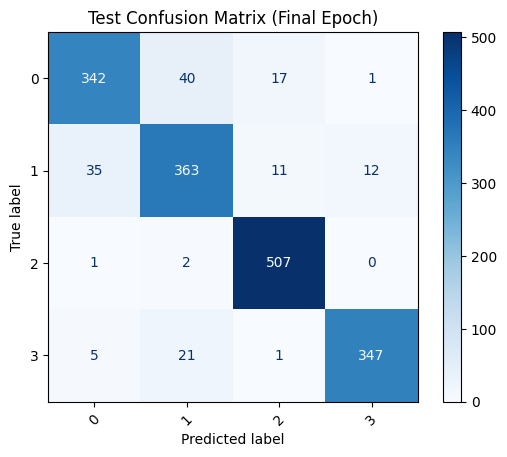

In [34]:
# Confusion matrix for the test dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib. pyplot as plt

# Compute the confusion matrix
cm=confusion_matrix(all_labels, all_preds)

# Plot it
display=ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap='Blues', xticks_rotation=45)
plt.title("Test Confusion Matrix (Final Epoch)")
plt.show()

# Create an inference function


This defines a function called predict_image that:

Takes an image path as input,

Uses your trained model to predict the class,

Returns the predicted class label from class_names,

Runs the model on a specified device (like "cpu" or "cuda").

In [ ]:
def predict_image(image, model, class_names, device):
    # Image preprocessing pipeline
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # ResNet expects 3 channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Transform the image
    image = transform(image).unsqueeze(0).to(device)

    # Inference
    model.eval()
    with torch.inference_mode():
        output = model(image)  # raw logits
        _, predicted = torch.max(output, dim=1)
        return class_names[predicted.item()]


# Create a simple user interface


Use Gradio (super simple and perfect for deep learning deployment).


In [ ]:
import gradio as gr

# load the model

model=models.resnet18(pretrained=False)  # pretrained=False since we’ll load our own weights
model.fc=torch.nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load("brain_tumor_model_1.pth", map_location='cpu'))

model.to(device)

# # Class labels
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# prediction function
def classify_mri(image):
  prediction=predict_image(image, model,class_names, device=device)
  return prediction

# create the gradio interface
interface=gr.Interface(
    fn=classify_mri,
    inputs=gr.Image(type='pil'),
    outputs=gr.Label(num_top_classes=4),
    title="Brain Tumor Classifier",
    description="Upload an MRI brain scan to detect tumor type: Glioma, Meningioma, No Tumor, or Pituitary.",
    live=True
)

# Launch the interface
interface.launch(share=True)